## Import libraries

In [2]:
import numpy as np
import wfdb
import pandas as pd
from glob import glob
import os
import biosppy
import pyhrv
import pyhrv.tools as tools
import json
import shap
import matplotlib.pyplot as plt
from tqdm import tqdm

## Data pre-processing
Extracting the HRV features

In [8]:
data_dir = "data/CPSC/"
recordpaths = glob(os.path.join(data_dir, '*.hea'))

for recordpath in recordpaths:
    patient_id = recordpath.split('/')[-1][:-4]
    signals, meta_data = wfdb.rdsamp(recordpath[:-4])
    sample_rate = meta_data['fs']
    signal_len = meta_data['sig_len']
    age = meta_data['comments'][0]
    sex = meta_data['comments'][1]
    dx = meta_data['comments'][2]
    age = age[5:] if age.startswith('Age: ') else np.NaN
    sex = sex[5:] if sex.startswith('Sex: ') else 'Unknown'
    dx = dx[4:] if dx.startswith('Dx: ') else ''


    folder_path = f"processing/{patient_id}/"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
        for signal in signals.T:
            try:
                # Get R-peaks series using biosppy
                t, filtered_signal, rpeaks = biosppy.signals.ecg.ecg(signal, sampling_rate=500, show=False)[:3]
            except:
                pass
            try:
                HRV_params = pyhrv.hrv(rpeaks=t[rpeaks])
            except:
                pass

            tools.hrv_export(HRV_params, path=folder_path)
    
        df_combined = pd.DataFrame()

        # Loop over each iteration of your for loop
        for filename in os.listdir(folder_path): 

            # Open the current file for reading
            with open(os.path.join(folder_path, filename)) as f:

                # Load the JSON data from the file into a Python object
                data = json.load(f)

                # Convert the Python object to a pandas DataFrame
                df = pd.json_normalize(data)

                # Select columns with at most one value
                cols_with_single_value = [col for col in df.columns if df[col].apply(lambda x: len(x) if isinstance(x, list) else 1).max() <= 1]
                df_with_single_value = df[cols_with_single_value].drop(columns=['Comment', 'Name'])
                df_with_single_value = df_with_single_value.dropna(axis=1)
                df_with_single_value = df_with_single_value._get_numeric_data()

                # Write the data to the combined JSON file

            df_combined = df_combined.append(df_with_single_value, ignore_index=True)

        df_combined.to_csv(f"csv/{patient_id}.csv", index=False)

Signal duration is to short for segmentation into 300000s. Input data will be returned.
Signal duration too short for SDANN computation.
CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a malfunction of the function. This function will be reviewed over the next updates to solve this issue
Not enough NNI samples for Detrended Fluctuations Analysis.
Signal duration is to short for segmentation into 300000s. Input data will be returned.
Signal duration too short for SDANN computation.
CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a malfunction of the function. This function will be reviewed over the next updates to solve this issue
Not enough NNI samples for Detrended Fluctuations Analysis.
Signal duration is to short for segmentation into 300000s. Input data will be returned.
Signal duration too short for SDANN computation.
CAUTION: The TINN computation is currently providing incorrect result

## HRV feature processing
using mean values of the leads

In [1]:
data_dir = "data/CPSC/"
# set the path of the directory where csv files are located
directory_path = 'csv'

# create an empty list to store the dataframes for each file
dfs = []
#patient_ids = []
leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# loop through each file in the directory
for file in os.listdir(directory_path):
        
        if file.endswith('.csv'):
            patient_id = file[:-4]
            file_path = os.path.join(directory_path, file)


            # read the csv file into a dataframe
            df = pd.read_csv(file_path)
            
            if len(df.T) > 39:
                df = df.drop(["dfa_alpha1", "dfa_alpha2"], axis=1)

            cols = df.columns.tolist()
            
            # mean of leads values
            datalistmean = [df.mean().tolist()]

            col_names = []

            for lead in leads:
                for col in cols:
                    col_names.append(col + "_" + lead)
                    
            #df = pd.DataFrame(datalist, columns=col_names)
            df_mean = pd.DataFrame(datalistmean, columns=cols)
            #df.insert(0, "patient_id", patient_id)
            df_mean.insert(0, "patient_id", patient_id)
            
            dfs.append(df_mean)
            
#result = pd.concat(dfs, axis=0, index=patient_ids)
result = pd.concat(dfs, axis=0, ignore_index=True)
result.sort_values(by=["patient_id"], ascending=True, inplace=True)

# check number of unique values in each column
unique_counts = result.nunique()

# get the names of columns with only one unique value
same_values_cols = unique_counts[unique_counts == 1].index.tolist()
# drop the columns with same values
result.drop(same_values_cols, axis=1, inplace=True)
result.to_csv("mean_hrv_features.csv", index=False)

NameError: name 'os' is not defined

## Define Dataset Classes and Labels

In [4]:
data_dir = "data/CPSC/"
classes = ['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE']
df_labels = pd.read_csv(os.path.join(data_dir, "labels.csv"))
df_X = pd.read_csv("mean_hrv_features.csv")
sel_ids = df_X["patient_id"].tolist()
df_labels = df_labels[df_labels['patient_id'].isin(sel_ids)]
df_labels.to_csv('data/CPSC/labelx.csv', index=False)
df_X.replace([np.inf, -np.inf], 100000, inplace=True) #replace infinity values to 100,000
df_X = df_X.merge(df_labels[['patient_id', 'fold']], on='patient_id')

## Machine Learning Implementation

### Import ml libraries

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

### Split and scale dataset

In [6]:
def split_data(seed=42):
    folds = range(1, 11)
    folds = np.random.RandomState(seed).permutation(folds)
    return folds[:8], folds[8:]

train_folds, test_folds = split_data()
feature_cols = df_X.columns[1:-1] # remove patient id and fold

X_train = df_X[df_X['fold'].isin(train_folds)][feature_cols].to_numpy()
X_test = df_X[df_X['fold'].isin(test_folds)][feature_cols].to_numpy()

# Preprocess the data using standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = df_labels[df_labels['fold'].isin(train_folds)][classes].to_numpy()
y_test = df_labels[df_labels['fold'].isin(test_folds)][classes].to_numpy()

Start training RF...
Optimal Threshold: 0.14
SNR Accuracy: 0.6761904761904762, F1_score: 0.3878116343490305
Optimal Threshold: 0.24
AF Accuracy: 0.9391941391941392, F1_score: 0.8628099173553719
Optimal Threshold: 0.12
IAVB Accuracy: 0.6322344322344322, F1_score: 0.28693181818181823
Optimal Threshold: 0.07
LBBB Accuracy: 0.8351648351648352, F1_score: 0.1758241758241758
Optimal Threshold: 0.34
RBBB Accuracy: 0.7054945054945055, F1_score: 0.5292740046838408
Optimal Threshold: 0.13
PAC Accuracy: 0.8234432234432234, F1_score: 0.47494553376906323
Optimal Threshold: 0.24
PVC Accuracy: 0.9076923076923077, F1_score: 0.633720930232558
Optimal Threshold: 0.11
STD Accuracy: 0.5648351648351648, F1_score: 0.3172413793103448
Optimal Threshold: 0.04
STE Accuracy: 0.6747252747252748, F1_score: 0.12598425196850394


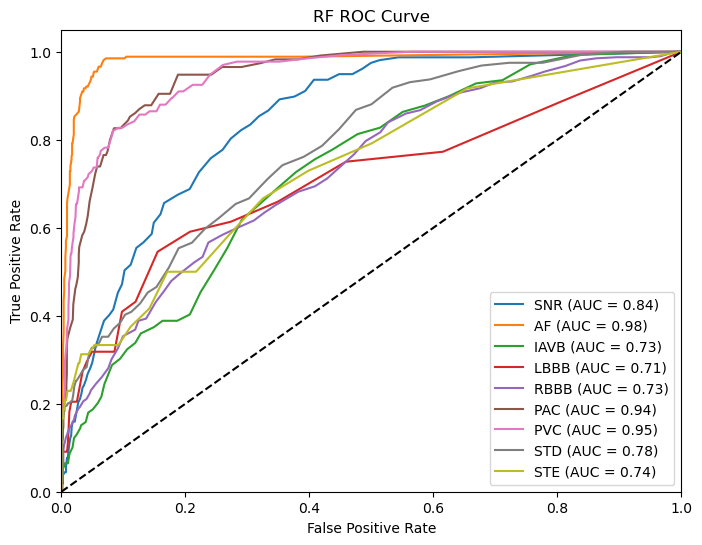

Start training DT...
Optimal Threshold: 1.0
SNR Accuracy: 0.8197802197802198, F1_score: 0.2721893491124261
Optimal Threshold: 1.0
AF Accuracy: 0.9282051282051282, F1_score: 0.8157894736842105
Optimal Threshold: 1.0
IAVB Accuracy: 0.8293040293040294, F1_score: 0.19931271477663232
Optimal Threshold: 1.0
LBBB Accuracy: 0.9347985347985348, F1_score: 0.13592233009708737
Optimal Threshold: 1.0
RBBB Accuracy: 0.6652014652014652, F1_score: 0.4193138500635324
Optimal Threshold: 1.0
PAC Accuracy: 0.9025641025641026, F1_score: 0.4088888888888889
Optimal Threshold: 1.0
PVC Accuracy: 0.9120879120879121, F1_score: 0.562043795620438
Optimal Threshold: 1.0
STD Accuracy: 0.8344322344322345, F1_score: 0.3505747126436782
Optimal Threshold: 1.0
STE Accuracy: 0.9340659340659341, F1_score: 0.19642857142857142


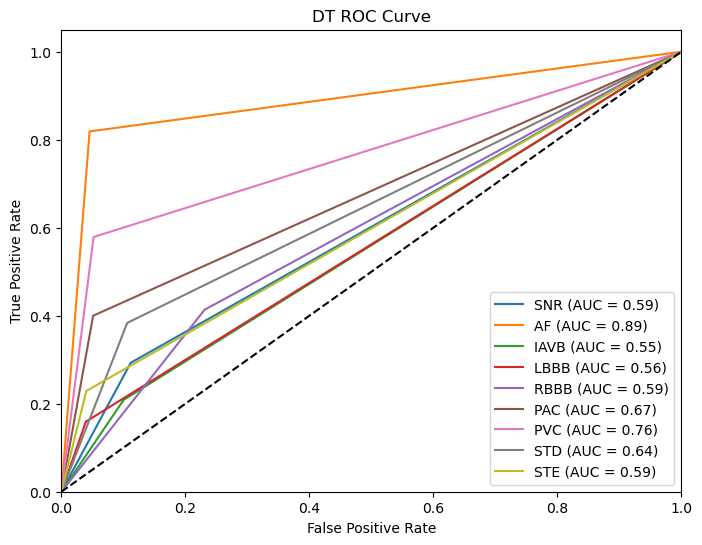

Start training LR...
Optimal Threshold: 0.1470931190378174
SNR Accuracy: 0.6908424908424908, F1_score: 0.4106145251396648
Optimal Threshold: 0.24965198063886013
AF Accuracy: 0.9472527472527472, F1_score: 0.8762886597938145
Optimal Threshold: 0.07095486001028091
IAVB Accuracy: 0.5098901098901099, F1_score: 0.2624035281146637
Optimal Threshold: 0.03075556435221226
LBBB Accuracy: 0.48131868131868133, F1_score: 0.08527131782945736
Optimal Threshold: 0.23599685457594866
RBBB Accuracy: 0.5860805860805861, F1_score: 0.519966015293118
Optimal Threshold: 0.11371456503292104
PAC Accuracy: 0.8490842490842491, F1_score: 0.4950980392156863
Optimal Threshold: 0.0883069690381451
PVC Accuracy: 0.8293040293040294, F1_score: 0.5010706638115631
Optimal Threshold: 0.16864881004770887
STD Accuracy: 0.7201465201465201, F1_score: 0.35906040268456374
Optimal Threshold: 0.04139201334844579
STE Accuracy: 0.7172161172161172, F1_score: 0.12669683257918554


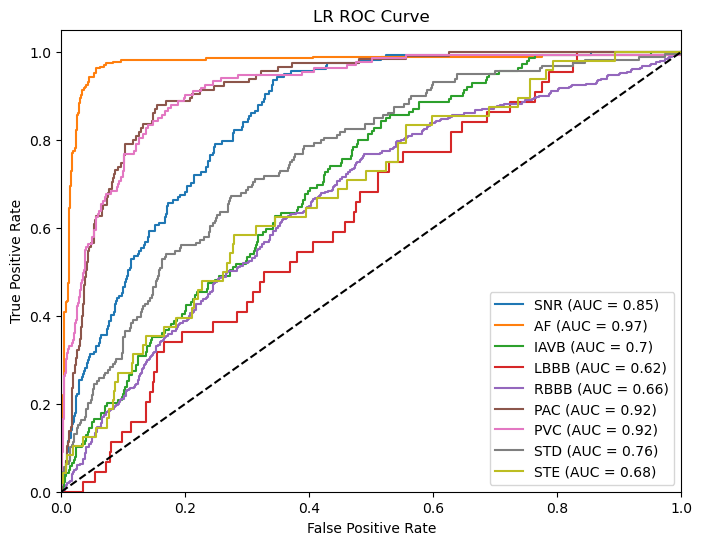

Start training SVM...
Optimal Threshold: 0.14863314369126535
SNR Accuracy: 0.6417582417582418, F1_score: 0.36245110821382004
Optimal Threshold: 0.16856608471569076
AF Accuracy: 0.9523809523809523, F1_score: 0.8877374784110537
Optimal Threshold: 0.11235446913226624
IAVB Accuracy: 0.5802197802197803, F1_score: 0.25293350717079527
Optimal Threshold: 0.038110263293728124
LBBB Accuracy: 0.6652014652014652, F1_score: 0.11946050096339114
Optimal Threshold: 0.25137816164958465
RBBB Accuracy: 0.5304029304029304, F1_score: 0.4988272087568412
Optimal Threshold: 0.11237026200904
PAC Accuracy: 0.8842490842490842, F1_score: 0.5561797752808988
Optimal Threshold: 0.07487129370937762
PVC Accuracy: 0.8842490842490842, F1_score: 0.5863874345549738
Optimal Threshold: 0.12133370204244047
STD Accuracy: 0.5948717948717949, F1_score: 0.29011553273427465
Optimal Threshold: 0.03235407289116315
STE Accuracy: 0.44761904761904764, F1_score: 0.09592326139088728


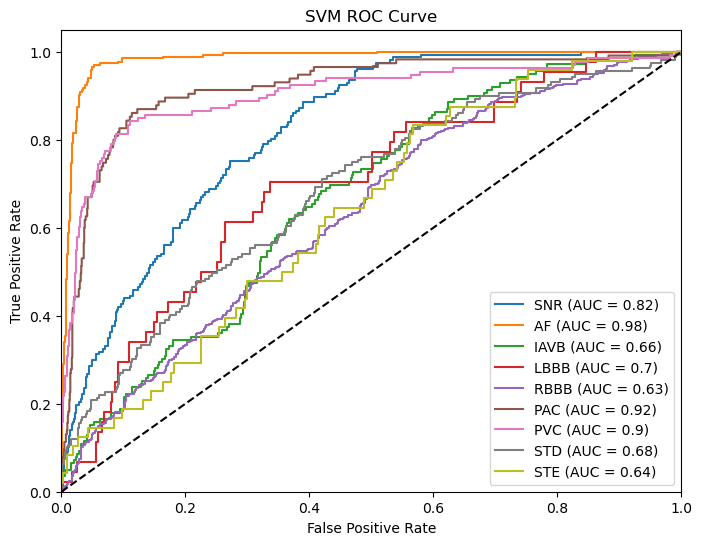

Start training LinerSVC...


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Optimal Threshold: 0.08007930120077554
SNR Accuracy: 0.6695970695970695, F1_score: 0.3913630229419703
Optimal Threshold: 0.15155277970044234
AF Accuracy: 0.9516483516483516, F1_score: 0.8846153846153847
Optimal Threshold: 0.04824068150042944
IAVB Accuracy: 0.5831501831501832, F1_score: 0.2658064516129032
Optimal Threshold: 0.028474522796188426
LBBB Accuracy: 0.8212454212454212, F1_score: 0.18120805369127516
Optimal Threshold: 0.20628593610180312
RBBB Accuracy: 0.5985347985347985, F1_score: 0.5054151624548736
Optimal Threshold: 0.017491984545617206
PAC Accuracy: 0.8695970695970696, F1_score: 0.5189189189189188
Optimal Threshold: 0.033808619927280535
PVC Accuracy: 0.8527472527472527, F1_score: 0.5421412300683371
Optimal Threshold: 0.119728007241401
STD Accuracy: 0.7076923076923077, F1_score: 0.357487922705314
Optimal Threshold: 0.037490648189264904
STE Accuracy: 0.8212454212454212, F1_score: 0.1527777777777778


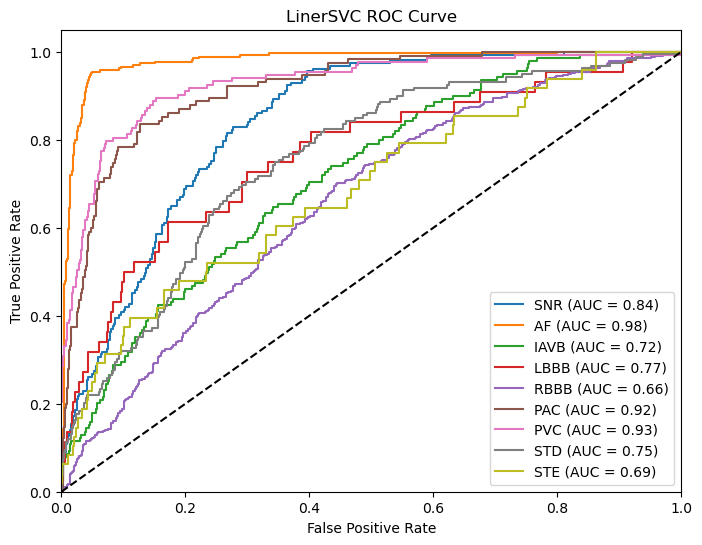

Start training MLP...


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Optimal Threshold: 0.11705682635518712
SNR Accuracy: 0.6952380952380952, F1_score: 0.4124293785310734
Optimal Threshold: 0.1400379968628173
AF Accuracy: 0.9413919413919414, F1_score: 0.864406779661017
Optimal Threshold: 0.051676993601045114
IAVB Accuracy: 0.4981684981684982, F1_score: 0.25785482123510295
Optimal Threshold: 0.027076100357319506
LBBB Accuracy: 0.6571428571428571, F1_score: 0.13011152416356878
Optimal Threshold: 0.19939571846275625
RBBB Accuracy: 0.5743589743589743, F1_score: 0.5113540790580319
Optimal Threshold: 0.08916208094862103
PAC Accuracy: 0.8798534798534798, F1_score: 0.551912568306011
Optimal Threshold: 0.13969196215206808
PVC Accuracy: 0.9084249084249084, F1_score: 0.6518105849582173
Optimal Threshold: 0.1322746163477875
STD Accuracy: 0.6835164835164835, F1_score: 0.3684210526315789
Optimal Threshold: 0.009023653560884916
STE Accuracy: 0.43956043956043955, F1_score: 0.09467455621301776


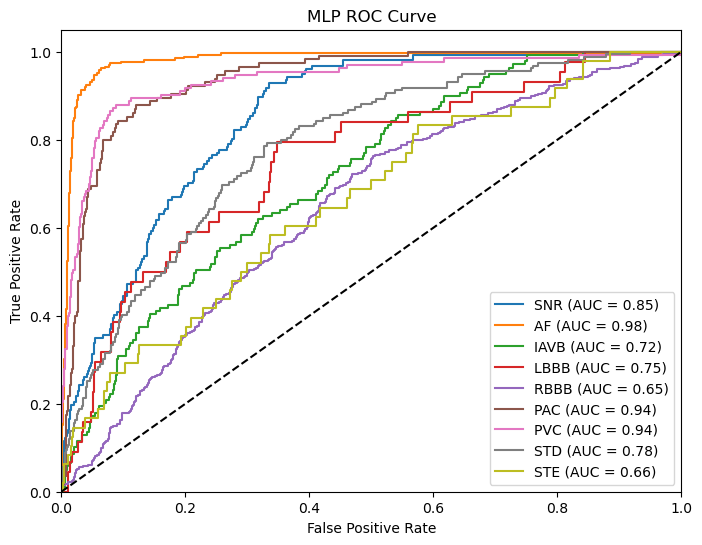

In [7]:
classifiers = ['RF', 'DT', 'LR', 'SVM', 'LinerSVC', 'MLP']
classes = ['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE']

for classifier in classifiers:
    # tune parameters
    if classifier == 'LR':
        model = LogisticRegression(max_iter=2000)#solver='lbfgs', max_iter=1000)
    elif classifier == 'RF':
        model = RandomForestClassifier()#n_estimators=300, max_depth=10)
    elif classifier == 'SVM':
        model = SVC(probability=True)
    elif classifier == 'LinearSVC':
        model = LinearSVC()
    elif classifier == 'DT':
        model = DecisionTreeClassifier()
    else:
        model = MLPClassifier(max_iter=500) #hidden_layer_sizes=(100, 50), max_iter=500)
    if classifier != 'MLP':
        model = OneVsRestClassifier(model)

    print(f'Start training {classifier}...')
    model.fit(X_train, y_train)

    #y_val_scores = model.predict_proba(X_val)
    y_test_scores = model.predict_proba(X_test)
    roc_auc = dict()
    fpr = dict()
    tpr = dict()
    optimal_thresholds = []

    
    plt.figure(figsize=(8,6))
    
    for i in range(len(classes)):
        fpr[i], tpr[i], thresholds = roc_curve(y_test[:, i], y_test_scores[:, i])
        opt_threshold = thresholds[np.argmax(tpr[i]-fpr[i])]
        optimal_thresholds.append(opt_threshold)
        acc = accuracy_score(y_test[:, i], y_test_scores[:, i]>=opt_threshold)
        f1s = f1_score(y_test[:, i], y_test_scores[:, i]>=opt_threshold)
        print('Optimal Threshold:', opt_threshold)
        print(f'{classes[i]} Accuracy: {acc}, F1_score: {f1s}')
        roc_auc[classes[i]] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[classes[i]]:0.2})')
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{classifier} ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(f'results/roc_{classifier}')
    plt.show()
    plt.close()

## Individual Diagnosis Confusion matrix

Start training RF...


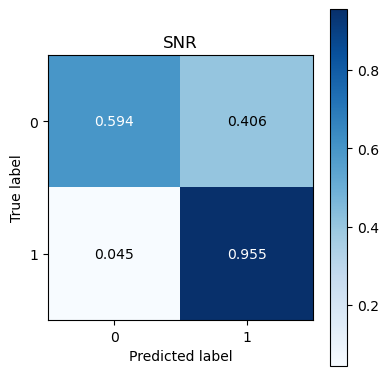

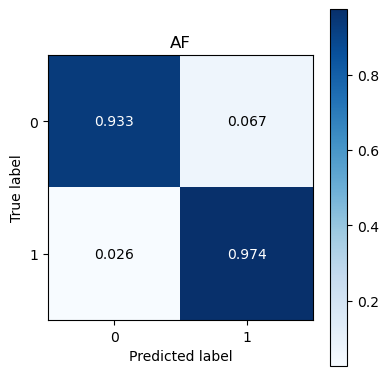

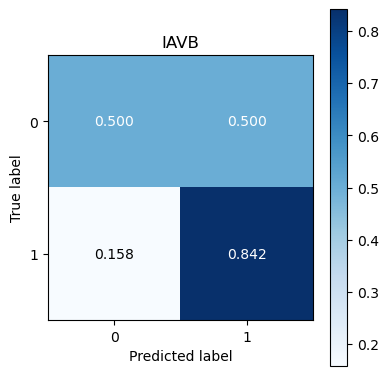

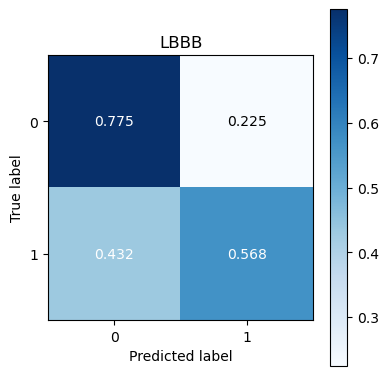

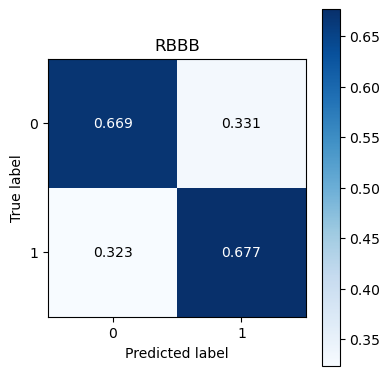

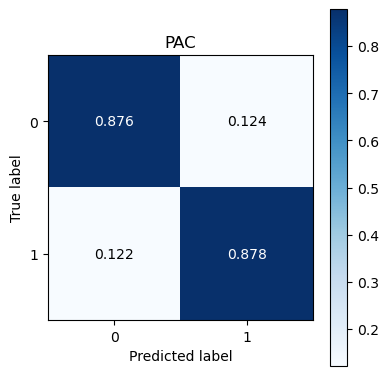

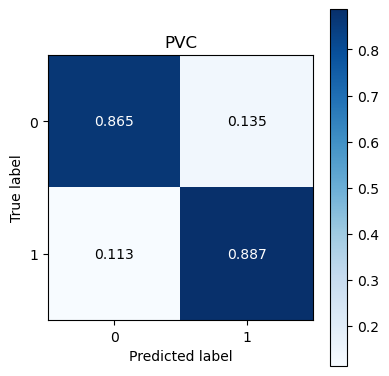

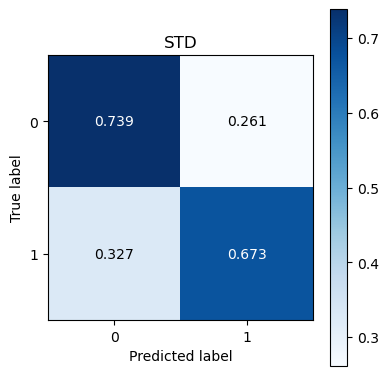

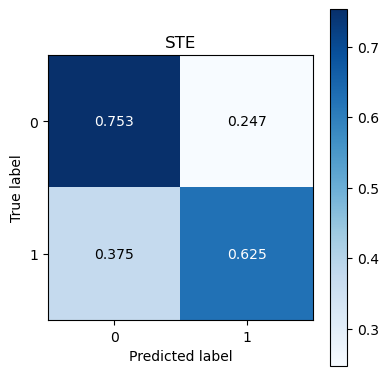

Start training LR...


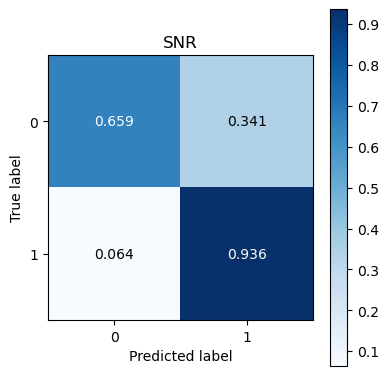

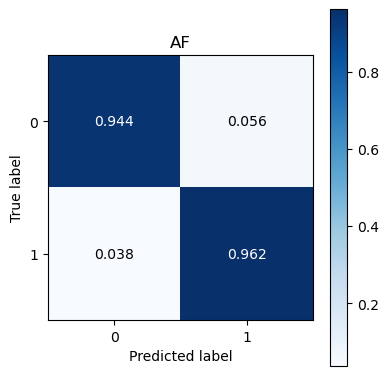

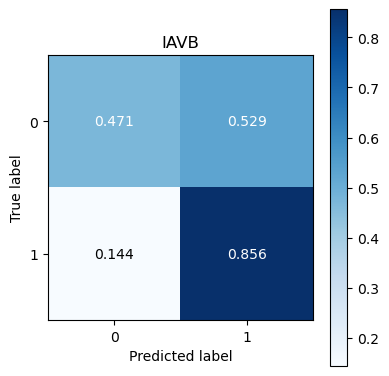

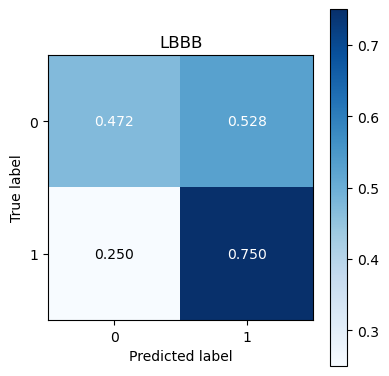

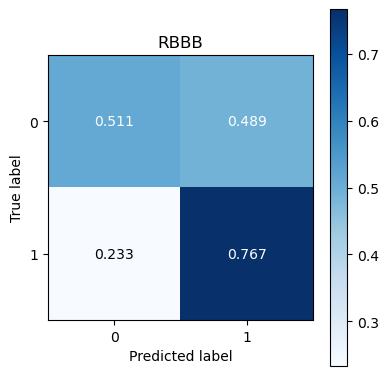

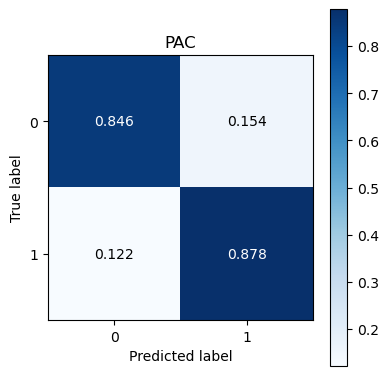

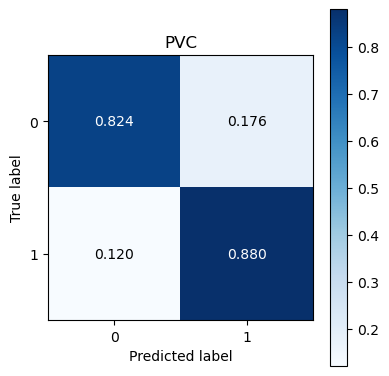

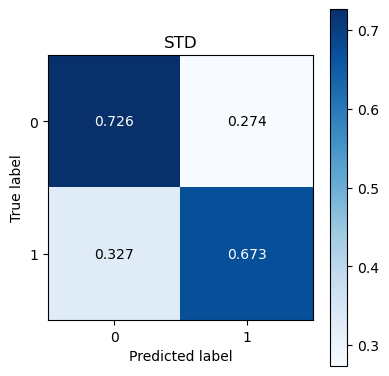

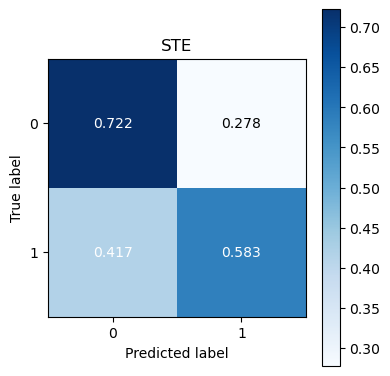

Start training LinerSVC...


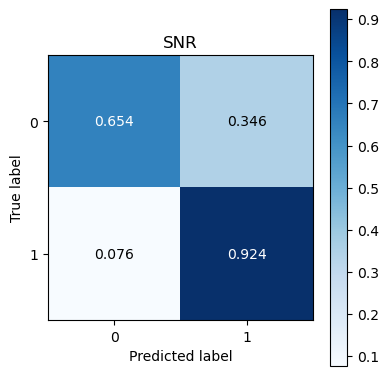

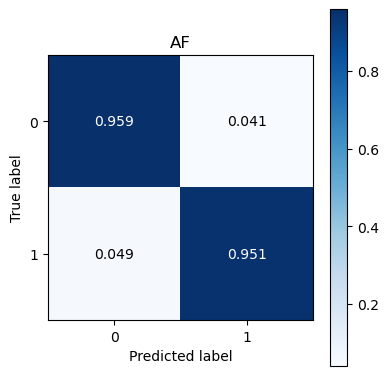

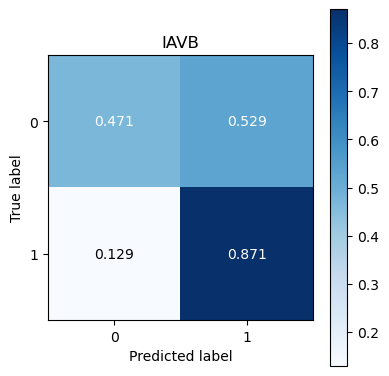

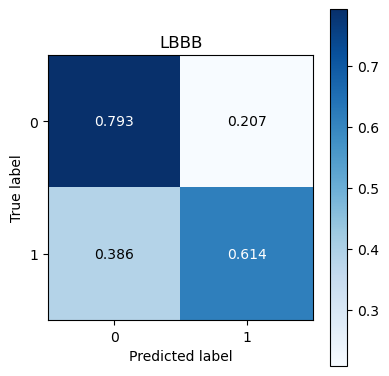

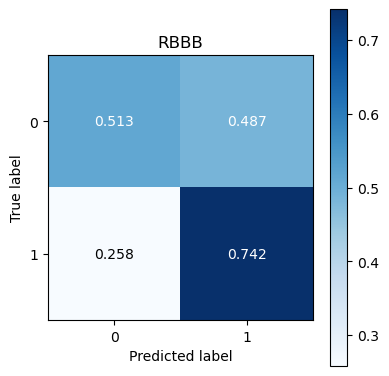

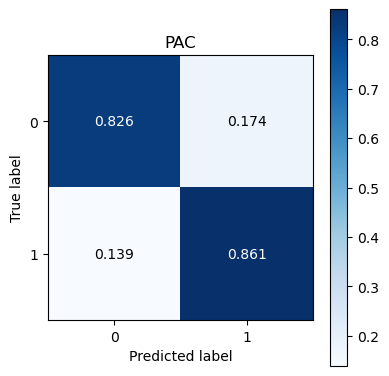

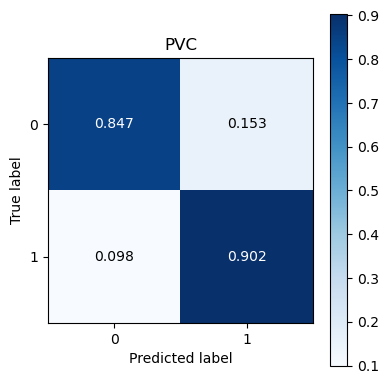

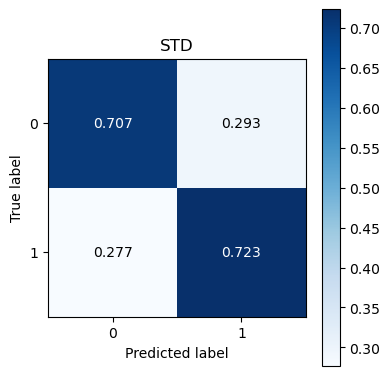

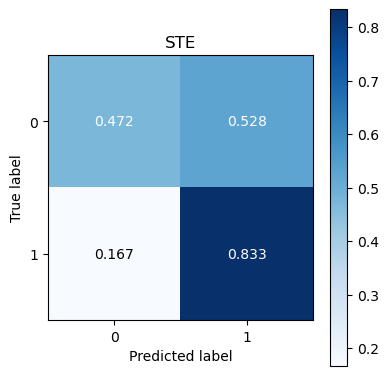

Start training MLP...


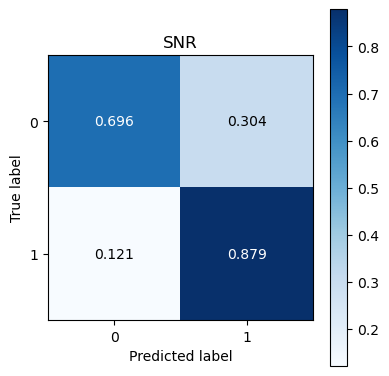

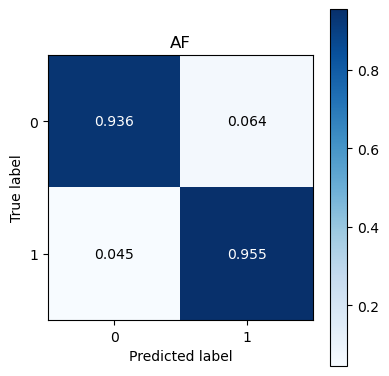

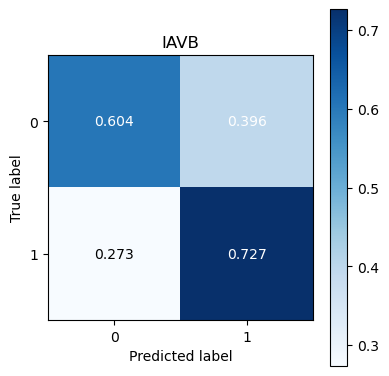

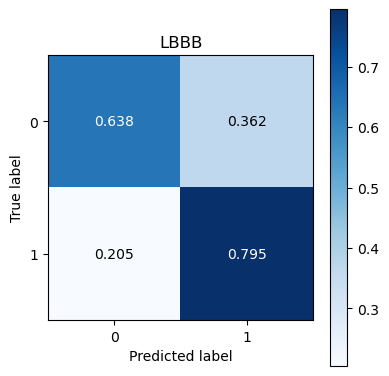

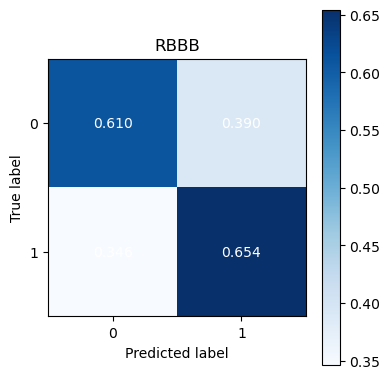

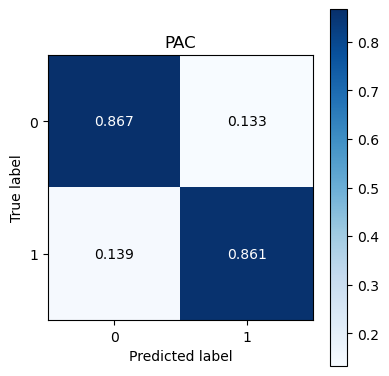

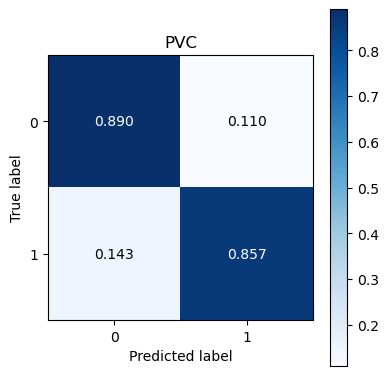

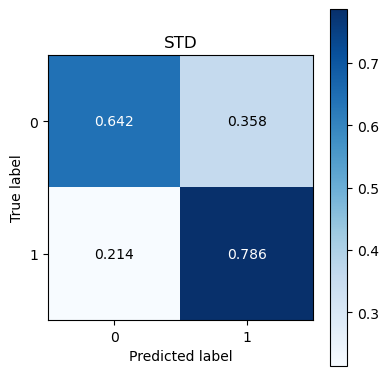

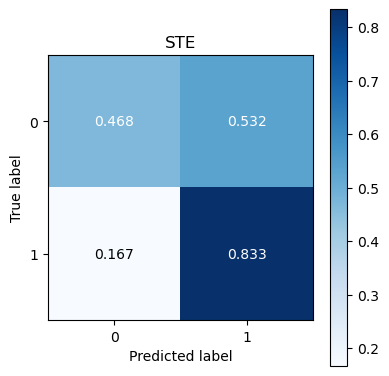

In [8]:
def plot_cm(y_trues, y_preds, normalize=True, cmap=plt.cm.Blues, classifier=classifier):
    classes = ['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE']
    for i, label in enumerate(classes):
        y_true = y_trues[:, i]
        y_pred = y_preds[:, i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        opt_threshold = thresholds[np.argmax(tpr-fpr)]
        cm = confusion_matrix(y_true, y_pred >= opt_threshold)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig, ax = plt.subplots(figsize=(4, 4))
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)        
        ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=[0, 1], yticklabels=[0, 1],
           title=label,
           ylabel='True label',
           xlabel='Predicted label')
        plt.setp(ax.get_xticklabels(), ha="center")

        fmt = '.3f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        np.set_printoptions(precision=3)
        fig.tight_layout()
        plt.show()
        plt.savefig(f'results/{label}_{classifier}.png')
        plt.close()


if __name__ == "__main__":
    
    classifiers = ['RF', 'LR', 'LinerSVC', 'MLP']

    for classifier in classifiers:
        # tune parameters
        if classifier == 'RF':
            model = RandomForestClassifier() #n_estimators=300, max_depth=10)
        elif classifier == 'LR':
            model = LogisticRegression(max_iter=2000) #solver='lbfgs', max_iter=1000)
        elif classifier == 'LinearSVC':
            model = LinearSVC(max_iter=1000)
        else:
            model = MLPClassifier(max_iter=1000)
        if classifier != 'MLP':
            model = OneVsRestClassifier(model)

        print(f'Start training {classifier}...')
        model.fit(X_train, y_train)

        #y_val_scores = model.predict_proba(X_val)
        y_test_scores = model.predict_proba(X_test)
        # plot confusion matrix
        plot_cm(y_test, y_test_scores, classifier)

## Confusion matrices
For four classifiers `RF`, `LR`, `LinearSVC`, `MLP`
This is to check for the best classifier

Start training RF...


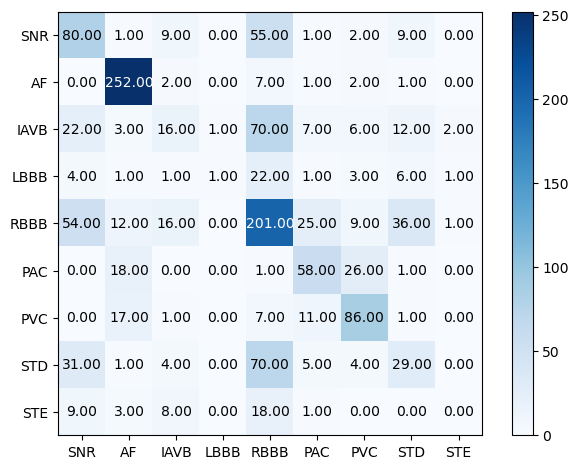

Start training LR...


<Figure size 640x480 with 0 Axes>

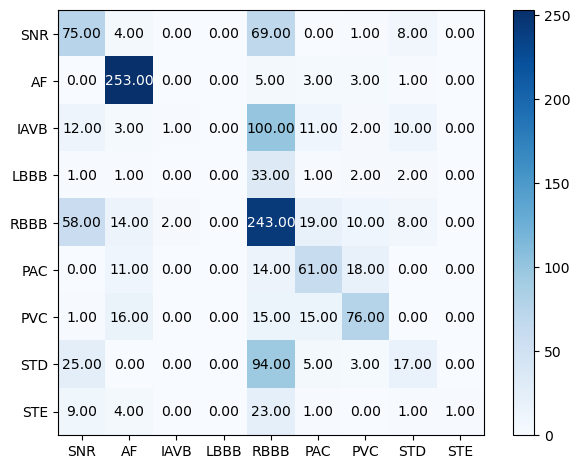

Start training LinerSVC...


<Figure size 640x480 with 0 Axes>

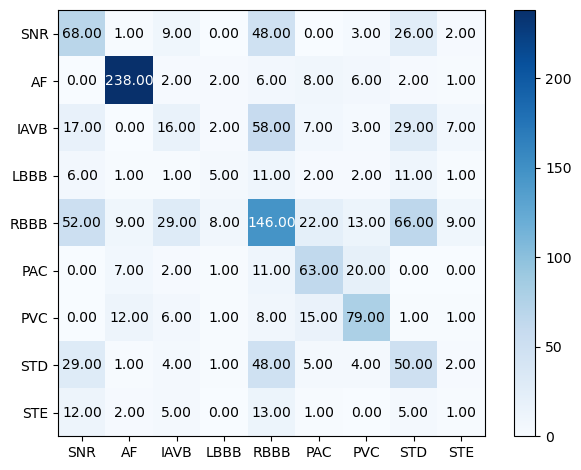

Start training MLP...


<Figure size 640x480 with 0 Axes>

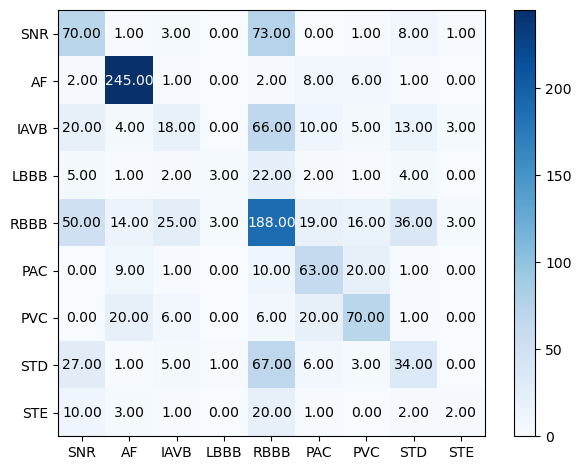

<Figure size 640x480 with 0 Axes>

In [9]:
def comp_confmat(y_true, y_test_scores, classifier=classifier, cmap=plt.cm.Blues):

    # extract the different classes
    classes = ['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE']

    confusion_matrix = [[0 for _ in range(9)] for _ in range(9)]
    for true_label, predicted_label in zip(y_true, y_test_scores):
        true_index = true_label.argmax()
        predicted_index = predicted_label.argmax()
        if true_index == predicted_index:
            confusion_matrix[true_index][true_index] += 1
        else:
            confusion_matrix[true_index][predicted_index] += 1

    ys = np.array(confusion_matrix)
    fig, axs = plt.subplots()
    im = axs.imshow(ys, cmap=cmap)
    axs.figure.colorbar(im, ax=axs)
    fmt = '.2f'
    xlabels = classes
    ylabels = ['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE']
    axs.set_xticks(np.arange(len(xlabels)))
    axs.set_yticks(np.arange(len(ylabels)))
    axs.set_xticklabels(xlabels)
    axs.set_yticklabels(ylabels)
    thresh = ys.max() / 2
    for i in range(ys.shape[0]):
        for j in range(ys.shape[1]):
            axs.text(j, i, format(ys[i, j], fmt),
                    ha='center', va='center',
                    color='white' if ys[i, j] > thresh else 'black')
    #np.set_printoptions(precision=2)
    fig.tight_layout()
    plt.show()
    plt.savefig(f'./cmatrix/{classifier}_cm.png')
    plt.clf()
    
if __name__ == '__main__':
    classifiers = ['RF', 'LR', 'LinerSVC', 'MLP']
    for classifier in classifiers:
        # tune parameters
        if classifier == 'RF':
            model = RandomForestClassifier() #n_estimators=300, max_depth=10)
        elif classifier == 'LR':
            model = LogisticRegression(max_iter=2000) #solver='lbfgs', max_iter=1000)
        elif classifier == 'LinearSVC':
            model = LinearSVC(max_iter=1000)
        else:
            model = MLPClassifier(max_iter=1000) #hidden_layer_sizes=(100, 50), max_iter=500)
        if classifier != 'MLP':
            model = OneVsRestClassifier(model)

        print(f'Start training {classifier}...')
        model.fit(X_train, y_train)

        #y_val_scores = model.predict_proba(X_val)
        y_test_scores = model.predict_proba(X_test)
        # plot confusion matrix
        comp_confmat(y_test, y_test_scores, classifier)